## Yuming Liu PS5

In [30]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
import pandas as pd
import requests

warnings.filterwarnings("ignore")

### Problem 1(a)

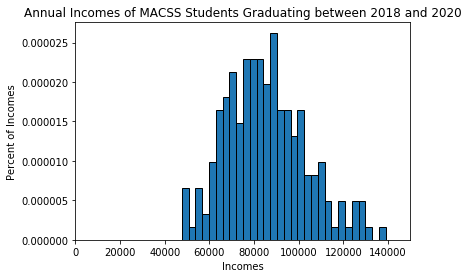

In [2]:
pts = np.loadtxt('data/incomes.txt')

num_bins = 30
count, bins, ignored = plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Students Graduating between 2018 and 2020') 
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])
plt.show()

### Problem 1(b)

In [3]:
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, scale=np.exp(mu), s=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, scale=np.exp(mu), s=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, scale=np.exp(mu), s=sigma) -
                       sts.lognorm.cdf(cut_lb, scale=np.exp(mu), s=sigma))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [4]:
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)

In [5]:
def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [6]:
def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [7]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, 0, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

mu_GMM1= 11.33359961340108  sig_GMM1= 0.21325529509280874


      fun: array([[6.39927099e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.14973834e-08, -2.93647018e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([11.33359961,  0.2132553 ])

In [8]:
mean_data, std_data = data_moments(pts)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', SD of points =', std_data)
print('Mean of model =', mean_model, ', SD of model =', std_model)
print('Error vector=', err1)
results
print('mean difference:', abs(mean_data-mean_model))
print('SD difference:', abs(std_data-std_model))

Mean of points = 85276.82360625811 , SD of points = 17992.542128046523
Mean of model = 85276.82405854983 , SD of model = 17992.541683009535
Error vector= [ 5.30380584e-09 -2.47345253e-08]
mean difference: 0.0004522917151916772
SD difference: 0.000445036988821812


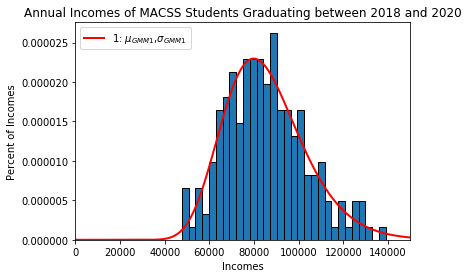

In [9]:
num_bins = 30
count, bins, ignored = plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Students Graduating between 2018 and 2020') 
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])

dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

### Problem 1(c)

In [10]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    
    return Err_mat

In [11]:
Err_mat = get_Err_mat2(pts, mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / pts.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[4.45167060e-02 1.68385288e+03]
 [1.68385288e+03 9.54184437e+08]]
[[ 2.40701668e+01 -4.24767141e-05]
 [-4.24767141e-05  1.12297423e-09]]


In [12]:
gmm_args = (pts, 0.0, 150000.0, W_hat2)
params_init = np.array([mu_GMM1, sig_GMM1])
results2 = opt.minimize(criterion, params_init, args = (gmm_args), tol = 1e-14,
                       method = 'L-BFGS-B', bounds = ((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2 = ', mu_GMM2, ' sig_GMM2 = ', sig_GMM2)

mu_GMM2 =  11.333599603618694  sig_GMM2 =  0.2132552944762079


In [13]:
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(pts, mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', std_data)
print('Mean of model =', mean_model2, ', Variance of model =', std_model2)
print('Error vector=', err2)
results2
print('mean difference:', abs(mean_data-mean_model2))
print('var difference:', abs(std_data-std_model2))

Mean of points = 85276.82360625811 , Variance of points = 17992.542128046523
Mean of model = 85276.82324643618 , Variance of model = 17992.541506074045
Error vector= [-4.21945751e-09 -3.45683491e-08]
mean difference: 0.00035982193367090076
var difference: 0.0006219724782567937


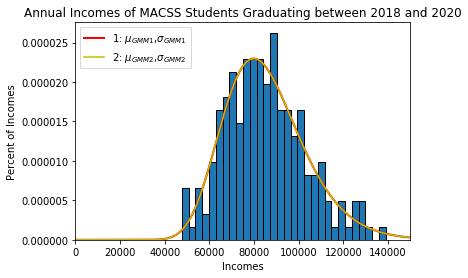

In [14]:
num_bins = 30
count, bins, ignored = plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Students Graduating between 2018 and 2020') 
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])

dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=1.5, color='y', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

### Problem 1(d)

In [15]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]
    
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [16]:
W_hat3 = np.eye(3)
gmm_args = (pts, 0, 150000, W_hat3)
results3 = opt.minimize(criterion3, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM3_1, sig_GMM3_1 = results3.x
print('mu_GMM3_1=', mu_GMM3_1, ' sig_GMM3_1=', sig_GMM3_1)
results3

mu_GMM3_1= 11.33670517992345  sig_GMM3_1= 0.21151351610769825


      fun: array([[2.44369927e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.42507144e-09, 4.61277452e-10])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 6
   status: 0
  success: True
        x: array([11.33670518,  0.21151352])

In [17]:
err3_1 = err_vec3(pts, mu_GMM3_1, sig_GMM3_1, 0.0, 150000.0, False).reshape(3,)
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
pct1, pct2, pct3 = model_moments3(mu_GMM3_1, sig_GMM3_1, 0.0, 150000.0)

print('Error vector = ', err3_1)
print('GMM criterion function:',results3.fun)
bpct = [bpct_1_dat, bpct_2_dat, bpct_3_dat],
pert = [pct1, pct2, pct3],
print('percent', ['Percent <75000','Percent 75000~100000','Percent > = 100000'])
print('Data Moments', bpct)
print('Model Moments', pert)

Error vector =  [ 1.13768176e-08  1.18261370e-08 -4.66305669e-08]
GMM criterion function: [[2.44369927e-15]]
percent ['Percent <75000', 'Percent 75000~100000', 'Percent > = 100000']
Data Moments ([0.3, 0.5, 0.2],)
Model Moments ([0.3000000034130453, 0.5000000059130685, 0.19999999067388663],)


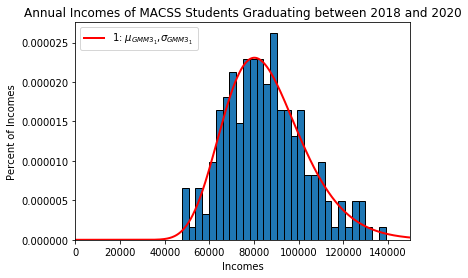

In [18]:
num_bins = 30
count, bins, ignored = plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Students Graduating between 2018 and 2020') 
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])

dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM3_1, sig_GMM3_1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3_1}$,$\sigma_{GMM3_1}$')
plt.legend(loc='upper left')

### Problem 1(e)

In [19]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >=  75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >=  100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >=  75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >=  100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [20]:
Err_mat3 = get_Err_mat3(pts, mu_GMM3_1, sig_GMM3_1, 0.0, 150000.0, False)
VCV2_3 = (1 / pts.shape[0]) * (Err_mat3 @ Err_mat3.T)
print(VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3)
print(W_hat2_3)

[[ 2.33333328 -0.99999998 -1.00000004]
 [-0.99999998  0.99999998 -1.00000003]
 [-1.00000004 -1.00000003  4.00000037]]
[[ 0.25761773 -0.14958449 -0.01246537]
 [-0.14958449  0.11911357 -0.07340719]
 [-0.01246537 -0.07340719  0.20221605]]


In [21]:
gmm_args = (pts, 0.0, 150000.0, W_hat2_3)
results4 = opt.minimize(criterion3, params_init, args = (gmm_args),method = 'L-BFGS-B')
mu_GMM3_2, sig_GMM3_2 = results4.x
print('mu_GMM3_2 = ', mu_GMM3_2, ' sig_GMM3_2 = ', sig_GMM3_2)

mu_GMM3_2 =  11.33359961340108  sig_GMM3_2 =  0.21325529509280874


In [22]:
err3_2 = err_vec3(pts, mu_GMM3_2, sig_GMM3_2, 0.0, 150000.0, False).reshape(3,)
pct1, pct2, pct3 = model_moments3(mu_GMM3_2, sig_GMM3_2, 0.0, 150000.0)

print('Error vector = ', err3_2)
print('GMM criterion function:',results4.fun)
bpct = [bpct_1_dat, bpct_2_dat, bpct_3_dat],
pert = [pct1, pct2, pct3],
print('percent', ['Percent <75000','Percent 75000~100000','Percent > = 100000'])
print('Data Moments', bpct)
print('Model Moments', pert)

Error vector =  [ 0.02208416 -0.00875996 -0.01122634]
GMM criterion function: [[0.00020989]]
percent ['Percent <75000', 'Percent 75000~100000', 'Percent > = 100000']
Data Moments ([0.3, 0.5, 0.2],)
Model Moments ([0.30662524929513346, 0.49562001855192594, 0.19775473215294084],)


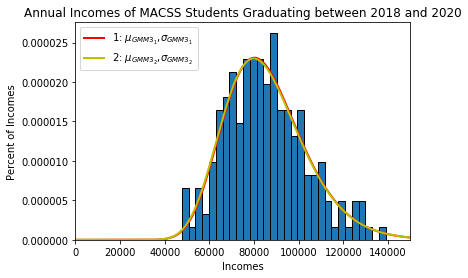

In [24]:
num_bins = 30
count, bins, ignored = plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Students Graduating between 2018 and 2020') 
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])

dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM3_1, sig_GMM3_1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3_1}$,$\sigma_{GMM3_1}$')
plt.legend(loc='upper left')

dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM3_2, sig_GMM3_2, 0.0, 150000),
         linewidth=2, color='y', label='2: $\mu_{GMM3_2}$,$\sigma_{GMM3_2}$')
plt.legend(loc='upper left')

### Problem 1(f)

In [26]:
mu = [mu_GMM1,mu_GMM2,mu_GMM3_1,mu_GMM3_2]
sigma = [sig_GMM1,sig_GMM2,sig_GMM3_1,sig_GMM3_2]
GMMV = [results.fun,results2.fun,results3.fun,results4.fun]

In [28]:
print(mu)
print(sigma)
print(GMMV)

[11.33359961340108, 11.333599603618694, 11.33670517992345, 11.33359961340108]
[0.21325529509280874, 0.2132552944762079, 0.21151351610769825, 0.21325529509280874]
[array([[6.39927099e-16]]), array([[4.28528567e-16]]), array([[2.44369927e-15]]), array([[0.00020989]])]


Therefore, we have the two moment and weighted model from part (c) has the smallest GMM function value. Hence, it is the model that fits the best.

### Problem 2 

In [32]:
data = pd.read_csv("data/sick.txt")

In [33]:
def err_vec(data, b0, b1, b2, b3):
    yhat = b0 + b1 * data['age'] + b2 * data['children'] + b3 * data['avgtemp_winter']
    y = data['sick']
    err_vec = yhat - y
    return err_vec

def crit(params, *args):
    b0, b1, b2, b3 = params
    data, W = args
    err = err_vec(data, b0, b1, b2, b3)
    crit_val = err.T @ W @ err
    return crit_val

In [34]:
b0, b1, b2, b3 = 1, 0, 0, 0
params_init = np.array([b0, b1, b2, b3])
W_hat = np.eye(df.shape[0])
gmm_args = (df, W_hat)
results = opt.minimize(crit, params_init, args = (gmm_args), tol = 1e-14,method = 'L-BFGS-B')
b0, b1, b2, b3 = results.x
print("b0=", b0)
print("b1=", b1)
print("b2=", b2)
print("b3=", b3)
print('GMM criterion function:', results.fun)
results

b0= 0.2516448636612042
b1= 0.012933470965564249
b2= 0.40050098470289774
b3= -0.009991709711286762
GMM criterion function: 0.0018212898060782808


      fun: 0.0018212898060782808
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.63237479e-07, -1.97918938e-06, -5.83402684e-06, -5.58679839e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 11
   status: 0
  success: True
        x: array([ 0.25164486,  0.01293347,  0.40050098, -0.00999171])